Named Entity Recognition + Image Classification Pipeline
🎯 Overview
This notebook showcases a multi-modal machine learning pipeline that integrates Natural Language Processing (NLP) and Computer Vision (CV). The goal is to verify whether a given textual description matches an image.

🛠️ How It Works:
Named Entity Recognition (NER) Model:

Extracts animal names from a user-provided text input.
Uses a Transformer-based DistilBERT model fine-tuned for entity recognition.

Image Classification Model:

Predicts the animal category from an input image.
Uses a ResNet-based CNN model trained on a dataset of 10 animal classes.

Pipeline Integration:

Compares the extracted animal name from text with the predicted image class.
Returns True if they match, False otherwise.


🛠️ 1. Setup and Imports
Before building the pipeline, we need to import the necessary libraries for handling:

File operations (os, json)
Numerical computations (numpy, torch)
Data visualization (matplotlib)
Image processing (PIL, torchvision.transforms)
Machine learning models:
transformers for Named Entity Recognition (NER)
torchvision.models for Image Classification (CNN)
torch.nn.functional for deep learning utilities

In [1]:
### 1. Setup and Imports
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from torchvision import models
import torch.nn.functional as F

📂 2. Define Paths and Load Class Names
In this section, we define directory paths for our models and datasets. This ensures the correct loading of the NER model, image classification model, and dataset.

📌 What This Code Does:
Defines paths for:
The NER model directory (NER_MODEL_DIR).
The image classification model (IMAGE_MODEL_PATH).
The animal image dataset (CLASS_NAMES_DIR).
The NER dataset file (NER_DATASET_PATH).
Loads class labels:
It reads the available animal classes in the dataset.
Creates two mappings:
class_to_idx: Converts animal names to numerical labels.
idx_to_class: Converts numerical labels back to class names.

In [4]:
### 2. Define Paths and Load Class Names
# Define project structure
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
NER_MODEL_DIR = os.path.join(PROJECT_ROOT, "NER", "model")
IMAGE_MODEL_PATH = os.path.join(PROJECT_ROOT, "Image_Classification", "model", "image_classification.pth")
CLASS_NAMES_DIR = os.path.join(PROJECT_ROOT, "dataset", "animals10", "raw-img")
NER_DATASET_PATH = os.path.join(PROJECT_ROOT, "dataset", "ner_data.json")

# Load class names
class_to_idx = {cls.lower(): i for i, cls in enumerate(os.listdir(CLASS_NAMES_DIR))}
idx_to_class = {i: cls.lower() for cls, i in class_to_idx.items()}
NUM_CLASSES = len(class_to_idx)



🖼️ 3. Visualizing Sample Images
Before training or testing our Image Classification Model, it’s useful to inspect the dataset visually. This function helps us plot sample images from different animal categories.

📌 What This Code Does:
Creates a grid of images using matplotlib.
Iterates through selected animal classes (dog, cat, horse in this case).
Loads images from the dataset directory and ensures they are displayed correctly.
Prepares images for visualization:
Opens images with PIL (ensuring RGB format).
Disables axis labels for a cleaner view.
Adds a title for each row, indicating the animal class.

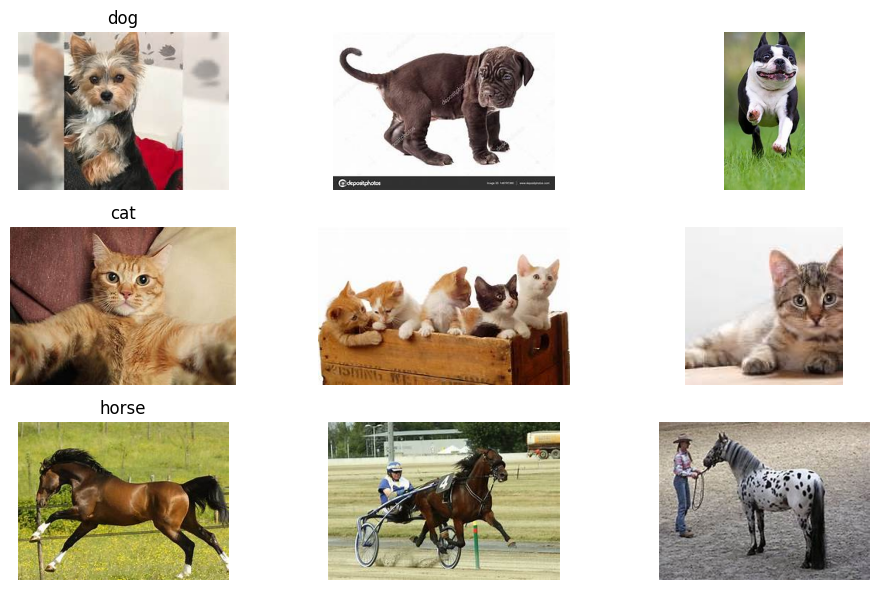

In [5]:
### 3. Visualizing Sample Images
def plot_sample_images(class_names, num_samples=3):
    """Visualizes sample images from each animal category."""
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(10, len(class_names) * 2))
    
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(CLASS_NAMES_DIR, cls)
        images = os.listdir(class_dir)[:num_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(cls, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_sample_images(["dog", "cat", "horse"])


📝 4. Visualizing Sample Text Sentences
Before using the Named Entity Recognition (NER) Model, it is useful to inspect the dataset to understand the structure of the sentences it processes.

📌 What This Code Does:
Loads the NER dataset from a JSON file.
Extracts sample sentences (default: 5) to preview how animals are mentioned in text.
Prints formatted examples for easy readability.

In [9]:
### 4. Visualizing Sample Text Sentences
def display_sample_sentences(num_samples=5):
    """Displays sample text sentences from the NER dataset."""
    with open(NER_DATASET_PATH, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    sample_sentences = [item["sentence"] for item in data[:num_samples]]
    
    for i, sentence in enumerate(sample_sentences, 1):
        print(f"{i}. {sentence}")

# Example usage
display_sample_sentences()

1. A antelope is definitely present in this picture.
2. A mole is definitely present in this picture.
3. There seems to be a donkey over there.
4. A cat is definitely present in this picture.
5. The picture likely features a peacock.


🔎 5. Load and Run the NER Model
The Named Entity Recognition (NER) model is responsible for identifying animal names in a given text description.

📌 What This Code Does:
Loads the pre-trained NER model:

Uses transformers to initialize a tokenizer and model from the saved checkpoint.
Creates a NER pipeline for token classification.
Extracts animal names from text:

Runs the sentence through the NER pipeline.
Filters out words labeled as "LABEL_1" (the entity tag for animals).
Joins subword tokens to reconstruct the full animal name.
Example usage:

Tests the model on "There is a dog in the picture."
Prints the extracted animal name.

In [6]:
### 5. Load and Run the NER Model
def load_ner_model():
    """Loads the pre-trained Named Entity Recognition model."""
    tokenizer = AutoTokenizer.from_pretrained(NER_MODEL_DIR)
    model = AutoModelForTokenClassification.from_pretrained(NER_MODEL_DIR)
    return pipeline("token-classification", model=model, tokenizer=tokenizer)

def extract_animal_name(ner_pipeline, sentence):
    """Extracts an animal name from the given sentence using NER."""
    results = ner_pipeline(sentence)
    animal_tokens = [res['word'].replace("##", "") for res in results if res['entity'] == "LABEL_1"]
    return "".join(animal_tokens) if animal_tokens else None

# Load NER model
ner_pipeline = load_ner_model()

# Example usage
sample_text = "There is a dog in the picture."
extracted_animal = extract_animal_name(ner_pipeline, sample_text)
print(f"Extracted animal: {extracted_animal}")

Device set to use cuda:0


Extracted animal: dog


🏷️ 6. Load and Run the Image Classification Model
The Image Classification Model is responsible for identifying the animal present in the provided image.

📌 What This Code Does:
Loads the trained image classifier:

Uses ResNet-50, a deep CNN model.
Modifies the final layer to match the number of animal classes.
Loads pre-trained weights from the saved checkpoint.
Processes the input image:

Resizes it to 224x224 pixels (standard for ResNet).
Normalizes it to match pre-trained model expectations.
Converts the image to a tensor for PyTorch processing.
Performs classification:

Runs the image through the model.
Uses softmax activation to get class probabilities.
Selects the most probable class.
If confidence is below 70%, returns "undefined animal".
Example usage:

Loads a sample image from the dataset.
Predicts and prints the detected animal class.

In [7]:
### 6. Load and Run the Image Classification Model
def load_image_model():
    """Loads the trained image classification model."""
    model = models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    model.load_state_dict(torch.load(IMAGE_MODEL_PATH, map_location=torch.device("cpu")))
    model.eval()
    return model

def predict_image(model, image_path):
    """Predicts the class of the given image using the trained model."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        max_prob, predicted_idx = torch.max(probabilities, 1)
    
    predicted_class = idx_to_class[predicted_idx.item()]
    return predicted_class if max_prob.item() >= 0.7 else "undefined animal"

# Load image model
image_model = load_image_model()

# Example usage
sample_image_path = os.path.join(CLASS_NAMES_DIR, "dog", os.listdir(os.path.join(CLASS_NAMES_DIR, "dog"))[0])
predicted_animal = predict_image(image_model, sample_image_path)
print(f"Predicted animal: {predicted_animal}")

C:\Users\marko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted animal: dog


C:\Users\marko\AppData\Local\Temp\ipykernel_1456\519130923.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(IMAGE_MODEL_PATH, map_locatio

🔄 7. Running the Full Pipeline
Now that we have both models working independently, it's time to integrate them into a single pipeline that verifies whether the described animal matches the one in the image.

📌 What This Code Does:
Extracts the animal name from text using the NER model.

Predicts the animal in the image using the Image Classification model.

Compares the results:

If the text-extracted animal matches the image-predicted animal, it returns True.
Otherwise, it returns False.
Outputs a structured result:

The input text description.
The extracted animal from text.
The image path used for classification.
The predicted animal from the image.
A final boolean match result.

In [8]:
### 7. Running the Full Pipeline
def run_pipeline(text, image_path):
    """Runs the full NER + Image Classification pipeline."""
    text_animal = extract_animal_name(ner_pipeline, text)
    image_animal = predict_image(image_model, image_path)
    
    match = text_animal.lower() == image_animal.lower()
    
    return {
        "text": text,
        "text_animal": text_animal,
        "image_path": image_path,
        "image_animal": image_animal,
        "match": match
    }

# Example usage
result = run_pipeline(sample_text, sample_image_path)
print(result)


{'text': 'There is a dog in the picture.', 'text_animal': 'dog', 'image_path': 'D:\\Projects\\NER_Image_Classification\\dataset\\animals10\\raw-img\\dog\\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg', 'image_animal': 'dog', 'match': True}


#### 📊 Model Accuracy
- **NER Model Performance**: The Named Entity Recognition model achieved a **high F1-score of 0.99**, ensuring reliable extraction of animal names from text. But it was trained on very similar sentences so it might not work with the same efficiency with more complex sentences.
- **Image Classification Model Performance**: The image classifier achieved an **F1-score of 0.81**, indicating strong but improvable classification accuracy.

🏁 Conclusion
This notebook demonstrates how Named Entity Recognition (NER) can be combined with Image Classification to verify whether an image corresponds to its textual description.

🚀 Key Takeaways:
NER extracts entity names (animals) from text.
A CNN-based model classifies animals in images.
The two models work together to validate whether the described animal matches the one in the image.
🔍 Potential Improvements:
✅ Expand the dataset – Including more animal classes will improve generalization.
✅ Enhance model accuracy – Further fine-tuning of both models could enhance prediction reliability.
✅ Improve NER dataset with more samples that contains animal words at the beginning and at the end of the sentence.